# Etivity 3 - Task 2: Regression
## Name: Brian Mortimer
## Student ID: 20258763

Open a new Jupyter notebook and name it etivity3_regression.ipynb. In this notebook, train three regression pipelines with Random Forest, Linear Regression and a third regressor of your choice as the final estimator, respectively, for predicting the value of `insurance_cost`.

Requirements:
- For each regressor, include data preparation and dimensionality reduction steps in the main pipeline.
- You can choose any regressor as the third one. Some options are SVR and MLPRegressor, but you are not limited to them.
- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-2 - Regression and Dimensionality Reduction.ipynb to evaluate and compare the models you have trained and pick the best one.
- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

### Data Loading & Preparation

In [47]:
# Imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import matplotlib.pyplot as plt
%matplotlib inline


In [17]:
# Functions
def load_insurance_data():
    """
    Load the insurance dataset from a CSV file.
    Returns a pandas DataFrame.
    """
    # Load the dataset
    df = pd.read_csv('insurance.csv')

    return df

In [18]:
# Load the dataset
df_original = load_insurance_data()
df = df_original.copy()

df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [20]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Define Preprocessing Pipeline

In [21]:
# transformers
# Transform gender to binary values "male"=0, "female"=1
gender_transformer = FunctionTransformer(
    lambda x: np.where(x == 'male', 0, 1)
)

# Transform region to binary values "northeast"=0, "southeast"=1, "southwest"=2, "northwest"=3
region_transformer = FunctionTransformer(
    lambda x: pd.get_dummies(x, drop_first=True)
)

# Transform smoker to binary values "yes"=1, "no"=0
smoker_transformer = FunctionTransformer(
    lambda x: np.where(x == 'yes', 1, 0)
)

# Transform BMI using log transformation to reduce skewness and impact of outliers
bmi_transformer  = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(np.log1p)), 
        ("scaler", StandardScaler())
    ]
)

# Transform children using cubic root transformation to reduce skewness
children_transformer = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.log1p)),
        ("scaler", StandardScaler())
    ]
)

# Define the preprocessor
preprocessor_pipeline = ColumnTransformer(
    transformers=[
        ('bmi', bmi_transformer, ['bmi']),
        ('age', StandardScaler(), ['age']),
        ('children', children_transformer, ['children']),
        ('gender', gender_transformer, ['gender']),
        ('region', region_transformer, ['region']),
        ('smoker', smoker_transformer, ['smoker'])
    ]
)


In [22]:
# split the data into features and target variable
X = df.drop(columns=['insurance_cost'])
y = df['insurance_cost']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define & Optimise Models

#### Random Forest

In [23]:
# Define the model pipeline for a Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_pipeline),
    ("reduce_dim", "passthrough"),
    ('ttr', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=10),
        func=np.log,
        inverse_func=np.exp
    ))
])
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age', StandardScaler(),
                                                  ['age']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['childr...
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8D3E2CB0>),
                                                  ['region']),
                                                 ('smoker',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8C02B760>),
                                                  ['smoker'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=10,
                                                                            n_jobs=-1,
                                                                            random_state=42)))])

In [24]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
    },
    {
        'reduce_dim': [RFE(RandomForestRegressor(random_state=42, n_jobs=-1))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
    },
    {
        'reduce_dim': ["passthrough"],
        'ttr__regressor__n_estimators': [10, 50, 100],
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
    }
]

search = GridSearchCV(rf_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.852:
Best parameters:  {'reduce_dim': 'passthrough', 'ttr__regressor__max_depth': 6, 'ttr__regressor__n_estimators': 100}


#### Linear Regression

In [25]:
# Define the model pipeline for linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_pipeline),
    ("reduce_dim", "passthrough"),
    ('ttr', TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log,
        inverse_func=np.exp
    ))
])

lr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age', StandardScaler(),
                                                  ['age']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['childr...
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8D3E2C20>),
                                                  ['gender']),
                                                 ('region',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8D3E2CB0>),
                                                  ['region']),
                                                 ('smoker',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8C02B760>),
                                                  ['smoker'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [26]:
# define the parameter grid for linear regression
N_FEATURES_OPTIONS = [2, 4, 6, 8]
FIT_INTERCEPT_OPTIONS = [True, False]

param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS,
    },
    {
        'reduce_dim': [RFE(RandomForestRegressor(random_state=42, n_jobs=-1))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS,
    },
    {
        'reduce_dim': ["passthrough"],
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS,
    }
]

search = GridSearchCV(lr_pipeline, param_grid, n_jobs=-1, cv=5, refit=True, error_score='raise')
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.681:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'ttr__regressor__fit_intercept': True}


#### MLP Regressor

In [27]:
# Custom wrapper for MLPRegressor to allow for hyperparameter tuning.
class MLPRegressorWrapper(BaseEstimator, TransformerMixin):
    """Custom wrapper for MLPRegressor to allow for hyperparameter tuning."""

    def __init__(self, n_units=100, n_layers=1, activation='relu', solver='adam', alpha=1e-4, learning_rate='constant', learning_rate_init=0.001):
        """
        Initialize the MLPRegressorWrapper.
        Args:
            n_units (int): Number of units in each hidden layer.
            n_layers (int): Number of hidden layers.
            activation (str): Activation function for the hidden layers.
            solver (str): Solver for weight optimization.
            alpha (float): L2 penalty (regularization term) parameter.
            learning_rate (str): Learning rate schedule for weight updates.
            learning_rate_init (float): Initial learning rate used.
        
        Returns:
            None
        """
        self.n_units = n_units
        self.n_layers = n_layers
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init


    def fit(self, X, y):
        """
        Fit the MLPRegressor to the training data.

        Args:
            X (array-like): Training data.
            y (array-like): Target values.

        Returns:
            self: Fitted estimator.
        """
        # Create the MLPRegressor with the specified parameters
        self.model = MLPRegressor(
            hidden_layer_sizes=(self.n_units,) * self.n_layers,
            activation=self.activation,
            solver=self.solver,
            alpha=self.alpha,
            learning_rate=self.learning_rate,
            learning_rate_init=self.learning_rate_init,
            random_state=42
        )
        # Fit the model to the training data
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        """
        Predict using the fitted MLPRegressor.

        Args:
            X (array-like): Input data.

        Returns:
            array: Predicted values.
        """
        return self.model.predict(X)
    
    def score(self, X, y):
        """
        Return the coefficient of determination R^2 of the prediction.

        Args:
            X (array-like): Input data.
            y (array-like): True values for X.

        Returns:
            float: R^2 score.
        """
        return self.model.score(X, y)


In [28]:
# Define the model pipeline for MLPRegressor
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_pipeline),
    ("reduce_dim", "passthrough"),
    ('ttr', TransformedTargetRegressor(
        regressor=MLPRegressorWrapper(),
        func=np.log,
        inverse_func=np.exp
    ))
])

mlp_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('age', StandardScaler(),
                                                  ['age']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['childr...
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8D3E2C20>),
                                                  ['gender']),
                                                 ('region',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8D3E2CB0>),
                                                  ['region']),
                                                 ('smoker',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000022F8C02B760>),
                                                  ['smoker'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=MLPRegressorWrapper()))])

In [29]:
print((y_train <= 0).sum()) 

0


In [45]:
# Define parameter grid for MLPRegressor
N_FEATURES_OPTIONS = [2, 3, 5, 8]
N_UNITS_OPTIONS = [50, 100]
HIDDEN_LAYER_OPTIONS = [2]
ACTIVATION_OPTIONS = ['relu', 'tanh', 'logistic']
SOLVER_OPTIONS = ['adam', 'sgd']
LEARNING_RATE_OPTIONS = ['constant', 'adaptive']
LEARNING_RATE_INIT_OPTIONS = [0.0005, 0.0001]
ALPHA_OPTIONS = [1e-4, 1e-3]

param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__n_units': N_UNITS_OPTIONS,
        'ttr__regressor__n_layers': HIDDEN_LAYER_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__solver': SOLVER_OPTIONS,
        ## Had to remove the below due to searching taking too long.
    #     'ttr__regressor__learning_rate': LEARNING_RATE_OPTIONS,
    #     'ttr__regressor__learning_rate_init': LEARNING_RATE_INIT_OPTIONS,
    #     'ttr__regressor__alpha': ALPHA_OPTIONS
    },
    {
        'reduce_dim': [RFE(RandomForestRegressor(random_state=42, n_jobs=-1))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__n_units': N_UNITS_OPTIONS,
        'ttr__regressor__n_layers': HIDDEN_LAYER_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__solver': SOLVER_OPTIONS,
    },
    {
        'reduce_dim': [SelectKBest(score_func=f_regression)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'ttr__regressor__n_units': N_UNITS_OPTIONS,
        'ttr__regressor__n_layers': HIDDEN_LAYER_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__solver': SOLVER_OPTIONS,
    },
    {
        'reduce_dim': ["passthrough"],
        'ttr__regressor__n_units': N_UNITS_OPTIONS,
        'ttr__regressor__n_layers': HIDDEN_LAYER_OPTIONS,
        'ttr__regressor__activation': ACTIVATION_OPTIONS,
        'ttr__regressor__solver': SOLVER_OPTIONS,
    }
]

search = GridSearchCV(mlp_pipeline, param_grid, n_jobs=-1, cv=5, refit=True, error_score='raise')
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_


Best CV score = 0.829:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    n_features_to_select=3), 'reduce_dim__n_features_to_select': 3, 'ttr__regressor__activation': 'relu', 'ttr__regressor__n_layers': 2, 'ttr__regressor__n_units': 100, 'ttr__regressor__solver': 'adam'}


Had to remove some of the parameters in the grid search because it was taking too long to train, this version already takes over 6 minutes on my PC.

### Model Evaluation & Comparison

In [48]:
def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [72]:
rf_mse, rf_mae, rf_r2 = evaluate_model(X_test, y_test, RF_best_model)
lr_mse, lr_mae, lr_r2 = evaluate_model(X_test, y_test, LR_best_model)
mlp_mse, mlp_mae, mlp_r2 = evaluate_model(X_test, y_test, MLP_best_model)

df_mse = pd.DataFrame({"Random Forest": rf_mse, "Linear Regression": lr_mse, "MLP Regressor": mlp_mse}, index=["MSE"])
df_mae = pd.DataFrame({"Random Forest": rf_mae, "Linear Regression": lr_mae, "MLP Regressor": mlp_mae}, index=["MAE"])
df_r2 = pd.DataFrame({"Random Forest": rf_r2, "Linear Regression": lr_r2, "MLP Regressor": mlp_r2}, index=["R2"])

metrics_df = pd.concat([df_mse, df_mae, df_r2], axis=0)
metrics_df = metrics_df.T
metrics_df.head()

,MSE,MAE,R2
Random Forest,1.652150e+07,1917.821548,0.883033
Linear Regression,4.563576e+07,5037.128616,0.676912
MLP Regressor,1.918164e+07,2506.314124,0.864200


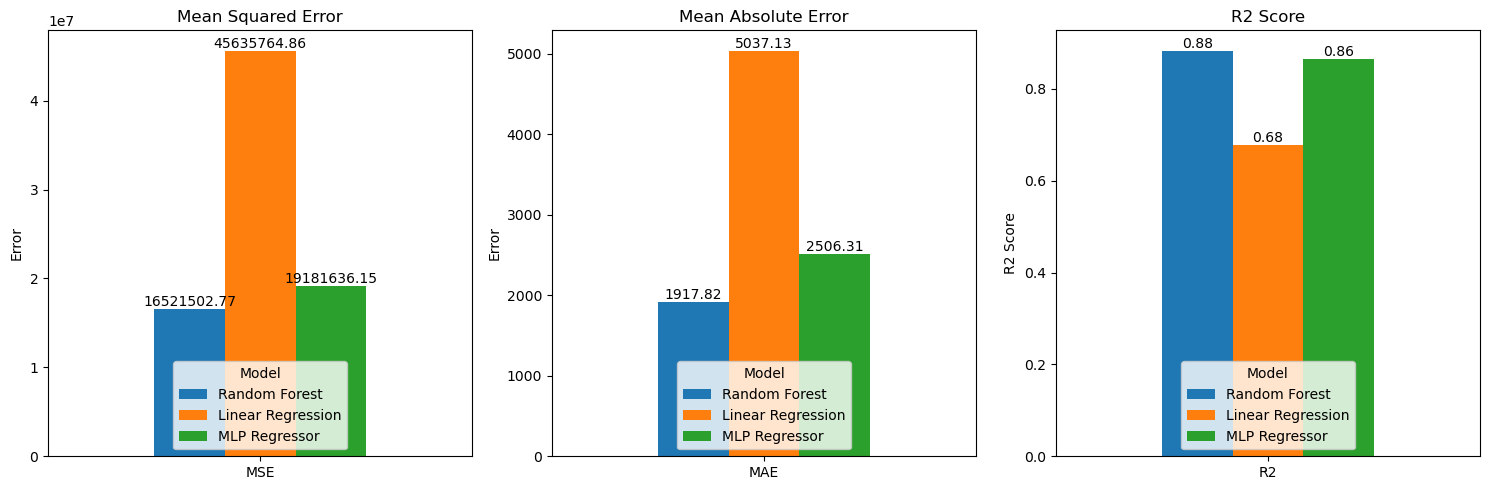

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_mse.plot(kind='bar', ax=axes[0])
df_mae.plot(kind='bar', ax=axes[1])
df_r2.plot(kind='bar', ax=axes[2])

axes[0].set_title('Mean Squared Error')
axes[1].set_title('Mean Absolute Error')
axes[2].set_title('R2 Score')

axes[0].set_ylabel('Error')
axes[1].set_ylabel('Error')
axes[2].set_ylabel('R2 Score')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title='Model', loc='lower center')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')  # Add labels to each bar

plt.tight_layout()
plt.show()

From the results we can conclude the following:
1. Random Forest performs the best across all metrics, with MLP in second and Linear Regression in last place.
    - The Linear Regressor is too simple a model and is not able to capture the complexities of the problem.
2. With the metrics we are looking for low Mean Squared Error and low Mean Absolute Error. Whereas we want a high R2 score, there for the Random Forest model is the clear winner.
3. The R2 score indicates how the models predictions match the actual values.

# Conclusion

I found this regression task to be challenging but I learnt a lot abut creating a full model pipeline which includes data preparation, model parameter optimization and model evaluation. This was really interesting and definitley showcased to me how it easy it can be to try different parameters or steps quickly and view the results.

Comparing my results to the results of my peers I can see that some students achieved similar results to me, however, some students were able to get better results. All of the regression examples I seen show that the Random Forest model was the better than the Linear Regressor. A few other peers achieved similar results with the MLP Regressor, I did find it interesting that the Gradient Boost model seems to perform very well in this task also. I seen Christos Koutsiaris used this technique and achieved good results with a RMSE=4,155.28(MSE=17,266,351), MAE=2422.15, R2=0.878. So these are strong results but my Random Forest model has slightly better MAE and R2.

I did add some techniques I found in my peers code to my project. After seeing Cian Moores solution I added the SelectKBest dimensionality reduction technique to my solution. I did find a small flaw in his solution with the configuration of his parameters and added a comment to his post. I also found Christos Koutsiaris added an interesting section at the end to view which inputs are most important to determining the outcome. I did try to get this to work on my project but didn't have time to complete it so I removed it.